# Landscape_explorer

The exploration of an energy landscape may focus on different features:
    * the extent explored
    * the identification of (deep) local minima
    * the identification of saddle points / transition points
In the following, we illustrate three different methods, which in a nutshell may be characterized by:
    * Basin-hopping: focus on local minima -- see below
    * Rapidly exploring random trees: focus on the extent visited and transition states
    * Hybrid: mix between BH and T-RRT
Results are presented for the following systems:
    * a complex trigonometric function defined 
    * BLN69, a toy protein model, whose conformation requires 3x69=207 Cartesian coordinates
    * Penta-alanine, aka Ala5
  

## We first define some useful functions

In [1]:
import re
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# A Function to be used later to retrieve specific output files
def find_file_in_output_directory(str, odir):
    cmd = "find %s -name *%s" % (odir,str)
    return os.popen(cmd).readlines()[0].rstrip()



def plot_dendogram_of_conformations(distances):
    # read the n(n-1)/2 distances and compute n
    lines = open(distances, "r").readlines()
    s = len(lines)
    n = int((1+math.sqrt(1+8*s))/2)

    # load distances into np array
    mat = np.zeros((n,n))
    for line in lines:
        aux = re.split("\s", line.rstrip())
        mat[int(aux[0]), int(aux[1])] = float(aux[2])
        mat[int(aux[1]), int(aux[0])] = float(aux[2])

    # plot dendogram
    dists = squareform(mat)
    linkage_matrix = linkage(dists, "single")
    dendrogram(linkage_matrix, labels= list(range(0,n+1)))
    plt.title("Conformations: dendogram based on lrmsd")
    plt.show()

## Example : trigonometric terrain

## Let us first visualize the graph of the trigonometric function studied:

$ f(x,y)=(x\sin(20y)+y\sin(20x))^2\cosh(\sin(10x)x)+(x\cos(10y)-y\sin(10x))^2\cosh(\cos(20y)y)$

Displayed


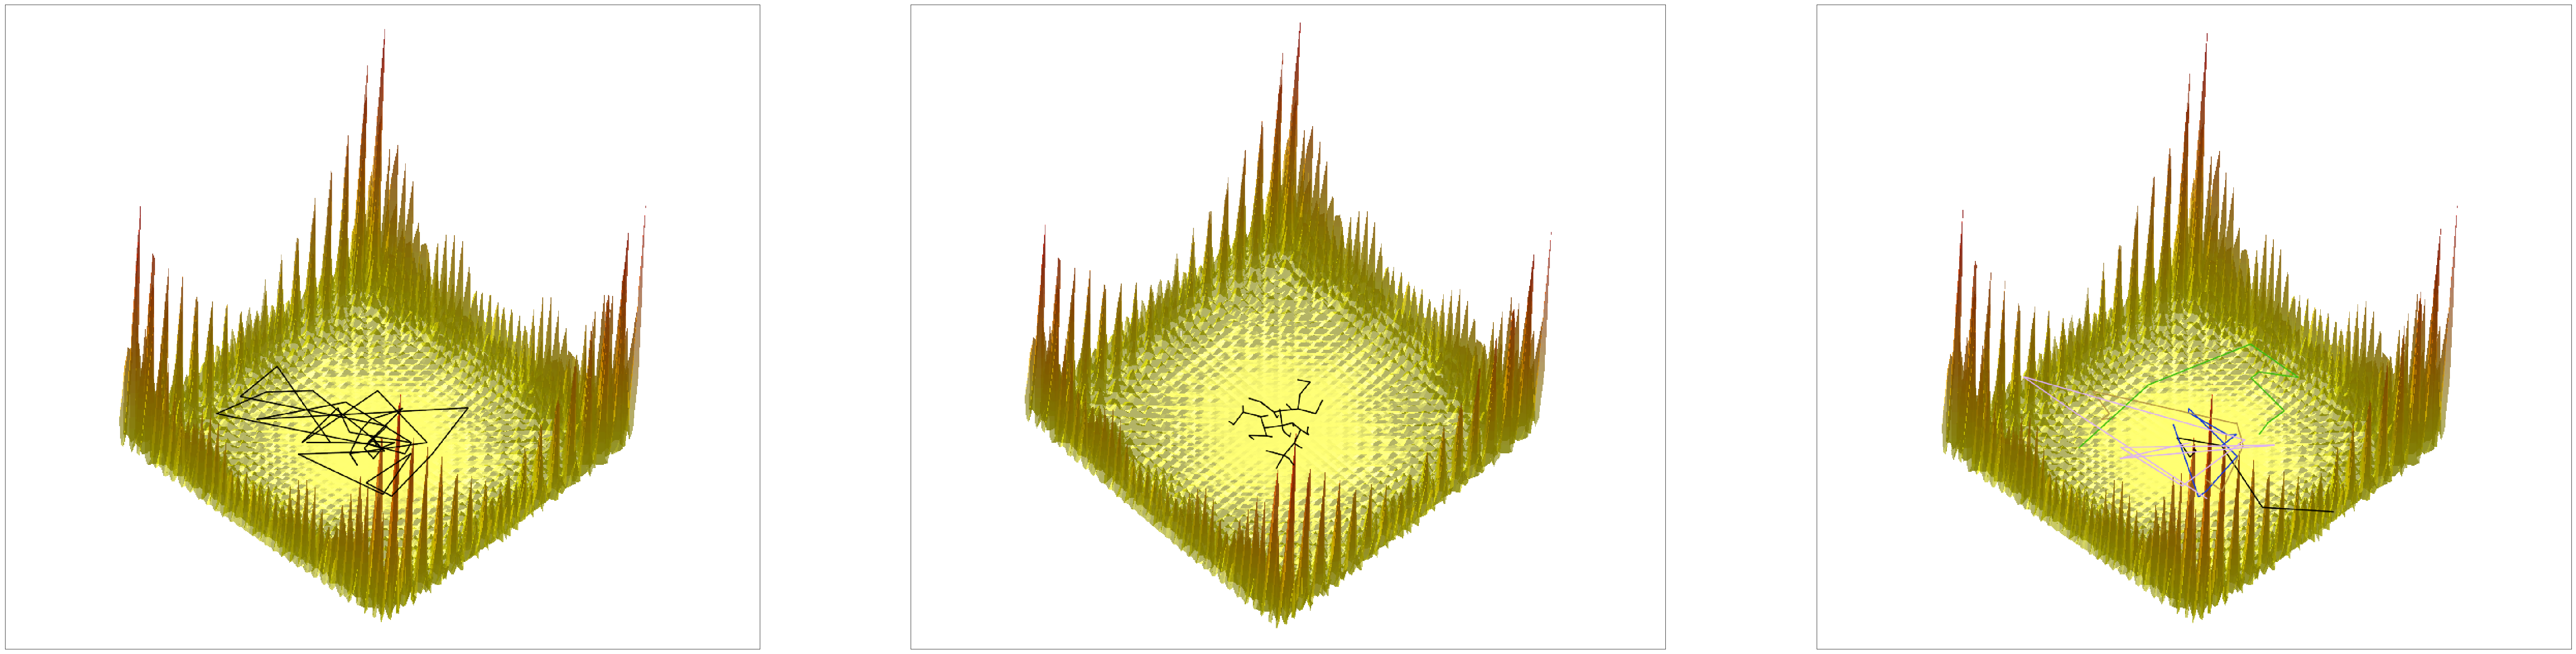

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

fig, ax = plt.subplots(1, 3, figsize=(100,100))
images = ["fig/bh-trigo-50.png", "fig/trrt-trigo-50.png", "fig/hybrid-trigo-50.png"]

for i in range(0,3):       
    ax[i].set_xticks([]); ax[i].set_yticks([])
    ax[i].imshow( Image.open(images[i]) )
print("Displayed")    






 The options of the <b>runTrigo</b> method in the next cell are:
 - <em>algorithm</em>: algorithm to use (BH, TRRT, hybrid)
 - <em>initSample</em>: plain text file listing at least one conformation for initaliwing the explorer
 - <em>movesetMode</em>: moveset method (global, interpolation)
 - <em>delta</em>: number of steps after what the algorithm attempts to adapt
 - <em>temperature</em>: initial temperature used in the acceptance test
 - <em>tempMode</em>: updating method after the acceptance test (default, probability or energy-range
 - <em>nbSamples</em>: number of samples to record before stopping the algorithm

In [3]:
import re  #regular expressions
import sys #misc system
import os
import pdb
import shutil # python 3 only

def runTrigo(algorithm, initSample = None, movesetMode = "global", delta = 5, temperature = 2., \
             tempMode = "probability", nbSamples = 10):

    odir = "tmp-results-trigo-%s" % algorithm 
    if os.path.exists(odir):
        os.system("rm -rf %s" % odir)
    os.system( ("mkdir %s" % odir) )
    
    program = None
    if algorithm == "BH":
        program = "sbl-landexp-BH-trigo-terrain.exe"
    elif algorithm == "TRRT":
        program = "sbl-landexp-TRRT-trigo-terrain.exe"
    elif algorithm == "hybrid":
        program = "sbl-landexp-hybrid-BH-TRRT-trigo-terrain.exe"
    # check executable exists and is visible
    exe = shutil.which(program)
    if not exe:
        sys.exit("Executable %s not found, exiting" % program)
    
    print(("Using executable %s\n" % exe))
    if initSample:
        cmd = "%s -v1 -l --init-sample=%s \
                --moveset-mode=%s --temperature=%f \
                --temperature-tuning-mode=%s --nb-samples=%d --directory=%s" \
                % (program, initSample, movesetMode, temperature, tempMode, nbSamples, odir)
    else:
        cmd = "%s -v1 -l --moveset-mode=%s \
                --temperature=%f --temperature-tuning-mode=%s \
                --nb-samples=%d --directory=%s" \
                % (program, movesetMode, temperature, tempMode, nbSamples, odir)
    if algorithm != "TRRT":
        cmd += " --adaptive-displace-delta=%d" % delta
    print(("Executing %s\n" % cmd)) 
    os.system(cmd)
        
    cmd = "ls %s" % odir
    ofnames = os.popen(cmd).readlines()
    print(("All output files in %s:" % odir),ofnames)
    


In [4]:
print("Marker : Calculation Started")
runTrigo("BH", initSample = "data/origin-2D.txt")
#runTrigo("TRRT", initSample = "data/origin-2D.txt")
#runTrigo("hybrid", initSample = "data/origin-2D.txt")
print("Marker : Calculation Ended")

Marker : Calculation Started
Using executable /user/fcazals/home/projects/proj-soft/sbl-install/bin/sbl-landexp-BH-trigo-terrain.exe

Executing sbl-landexp-BH-trigo-terrain.exe -v1 -l --init-sample=data/origin-2D.txt                 --moveset-mode=global --temperature=2.000000                 --temperature-tuning-mode=probability --nb-samples=10 --directory=tmp-results-trigo-BH --adaptive-displace-delta=5

All output files in tmp-results-trigo-BH: ['sbl-landexp-BH-trigo-terrain__log.txt\n', 'sbl-landexp-BH-trigo-terrain__minima_energies.txt\n', 'sbl-landexp-BH-trigo-terrain__minima.txt\n', 'sbl-landexp-BH-trigo-terrain__samples_energies.txt\n', 'sbl-landexp-BH-trigo-terrain__samples.txt\n']
Marker : Calculation Ended


### The files containing the samples, minima, and the associated energies are now easily exploited

In [5]:
# Retrieve the file containing the minima and samples
odir = "tmp-results-trigo-BH"
samples = find_file_in_output_directory("samples.txt",  odir)
samples_energies = find_file_in_output_directory("samples_energies.txt", odir)
print("Number of samples:", os.popen( ("wc -l %s" % samples)).readlines())

minima = find_file_in_output_directory("minima.txt",  odir)
minima_energies = find_file_in_output_directory("minima_energies.txt",  odir)

print("Number of local minima:", os.popen( ("wc -l %s" % minima)).readlines())




Number of samples: ['10 tmp-results-trigo-BH/sbl-landexp-BH-trigo-terrain__samples.txt\n']
Number of local minima: ['10 tmp-results-trigo-BH/sbl-landexp-BH-trigo-terrain__minima.txt\n']


## Example: BLN69

Recall that BLN69 is a toy protein model made of 69 pseudo-amino acids
which are either hydrophoBic, hydrophiLic,or Neutral:


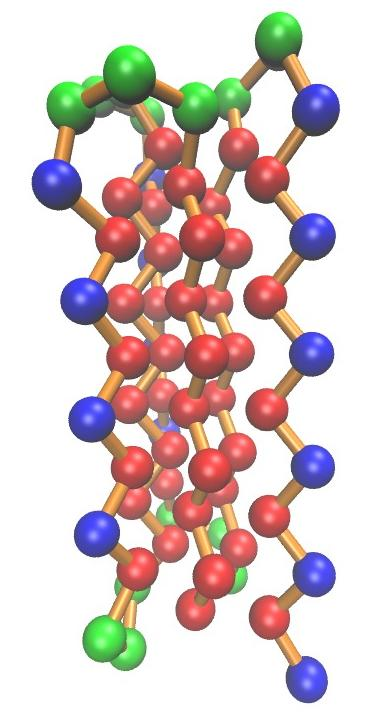

In [6]:
from IPython.display import Image
Image(filename='fig/bln69-visu7305.jpg')

 The options of the <b>runBLN69</b> method in the next cell are:
 - <em>algorithm</em>: algorithm to use (BH, TRRT, hybrid)
 - <em>ffParameters</em>: XML file listing the force field parameters for BLN69
 - <em>initSample</em>: plain text file listing at least one conformation for initaliwing the explorer
 - <em>movesetMode</em>: moveset method (atomic, global, interpolation)
 - <em>delta</em>: number of steps after what the algorithm attempts to adapt
 - <em>temperature</em>: initial temperature used in the acceptance test
 - <em>tempMode</em>: updating method after the acceptance test (default, probability or energy-range
 - <em>nbSamples</em>: number of samples to record before stopping the algorithm

In [6]:
import re  #regular expressions
import sys #misc system
import os
import pdb
import shutil # python 3 only

def runBLN69(algorithm, ffParameters = "data/bln69.xml", initSample = None, movesetMode = "atomic", delta = 5, temperature = 2., \
             tempMode = "probability", nbSamples = 10):

    odir = "tmp-results-BLN-%s" % algorithm 
    if os.path.exists(odir):
        os.system("rm -rf %s" % odir)
    os.system( ("mkdir %s" % odir) )
    
    program = None
    if algorithm == "BH":
        program = "sbl-landexp-BH-BLN.exe"
    elif algorithm == "TRRT":
        program = "sbl-landexp-TRRT-BLN.exe"
    elif algorithm == "hybrid":
        program = "sbl-landexp-hybrid-BH-TRRT-BLN.exe"
    # check executable exists and is visible
    exe = shutil.which(program)
    if not exe:
        sys.exit("Executable %s not found, exiting" % program)
    
    print(("Using executable %s\n" % exe))
    if initSample:
        cmd = "%s -v1 -l  --sampling-viewer vmd --ff-parameters-filename=%s --init-sample=%s \
                --moveset-mode=%s --temperature=%f \
                --temperature-tuning-mode=%s --nb-samples=%d --directory=%s" \
                % (program, ffParameters, initSample, movesetMode, temperature, tempMode, nbSamples, odir)
    else:
        cmd = "%s -v1 -l  --sampling-viewer vmd --ff-parameters-filename=%s --moveset-mode=%s \
                --temperature=%f --temperature-tuning-mode=%s \
                --nb-samples=%d --directory=%s" \
                % (program, ffParameters, movesetMode, temperature, tempMode, nbSamples, odir)
    if algorithm != "TRRT":
        cmd += " --adaptive-displace-delta=%d" % delta
    print(("Executing %s\n" % cmd))
    os.system(cmd)
        
    cmd = "ls %s" % odir
    ofnames = os.popen(cmd).readlines()
    print(("All output files in %s:" % odir),ofnames)
    

In [7]:
print("Marker : Calculation Started")
#runBLN69("BH", initSample = "data/bln69_global_minimum.txt")
runBLN69("TRRT", initSample = "data/bln69_global_minimum.txt")
#runBLN69("hybrid", initSample = "data/bln69_global_minimum.txt")
print("Marker : Calculation Ended")

Marker : Calculation Started
Using executable /user/fcazals/home/projects/proj-soft/sbl-install/bin/sbl-landexp-TRRT-BLN.exe

Executing sbl-landexp-TRRT-BLN.exe -v1 -l  --sampling-viewer vmd --ff-parameters-filename=data/bln69.xml --init-sample=data/bln69_global_minimum.txt                 --moveset-mode=atomic --temperature=2.000000                 --temperature-tuning-mode=probability --nb-samples=10 --directory=tmp-results-BLN-TRRT

All output files in tmp-results-BLN-TRRT: ['sbl-landexp-TRRT-BLN__log.txt\n', 'sbl-landexp-TRRT-BLN__minima_energies.txt\n', 'sbl-landexp-TRRT-BLN__minima.txt\n', 'sbl-landexp-TRRT-BLN__minima.vmd\n', 'sbl-landexp-TRRT-BLN__minimum10.pdb\n', 'sbl-landexp-TRRT-BLN__minimum11.pdb\n', 'sbl-landexp-TRRT-BLN__minimum1.pdb\n', 'sbl-landexp-TRRT-BLN__minimum2.pdb\n', 'sbl-landexp-TRRT-BLN__minimum3.pdb\n', 'sbl-landexp-TRRT-BLN__minimum4.pdb\n', 'sbl-landexp-TRRT-BLN__minimum5.pdb\n', 'sbl-landexp-TRRT-BLN__minimum6.pdb\n', 'sbl-landexp-TRRT-BLN__minimum7.pdb\n

### As previsouly, we easily retrieve and exploit the samples and local minima generated

In [8]:
# Retrieve the file containing the minima and samples
odir = "tmp-results-BLN-TRRT"
samples = find_file_in_output_directory("samples.txt",  odir)
samples_energies = find_file_in_output_directory("samples_energies.txt",  odir)
print("Number of samples:", os.popen( ("wc -l %s" % samples)).readlines())

minima = find_file_in_output_directory("minima.txt",  odir)
minima_energies = find_file_in_output_directory("minima_energies.txt",  odir)

print("Number of local minima:", os.popen( ("wc -l %s" % minima)).readlines())


Number of samples: ['10 tmp-results-BLN-TRRT/sbl-landexp-TRRT-BLN__samples.txt\n']
Number of local minima: ['1 tmp-results-BLN-TRRT/sbl-landexp-TRRT-BLN__minima.txt\n']


## Let us plot a dendogram of conformations, based on the matrix of all pairwise lrmsd distances, computed with the executable sbl-lrmsd-all-pairs.exe

 
        

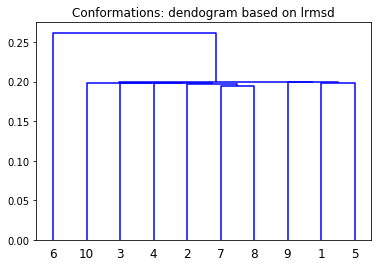

In [15]:
# NB: since TRRT  generates samples rather than local minima;we thus compute distances between samples
exe = shutil.which("sbl-lrmsd-all-pairs.exe") 
if not exe: 
    print("Executable sbl-lrmsd-all-pairs.exe not found; get it from the package Molecular_distances.")
    
os.system( ("%s --points-file  tmp-results-BLN-TRRT/sbl-landexp-TRRT-BLN__samples.txt") % exe )
plot_dendogram_of_conformations("all_distances.txt")

## Example : penta-alanine (Ala5)

 Let us first visuzalize this penta-peptide

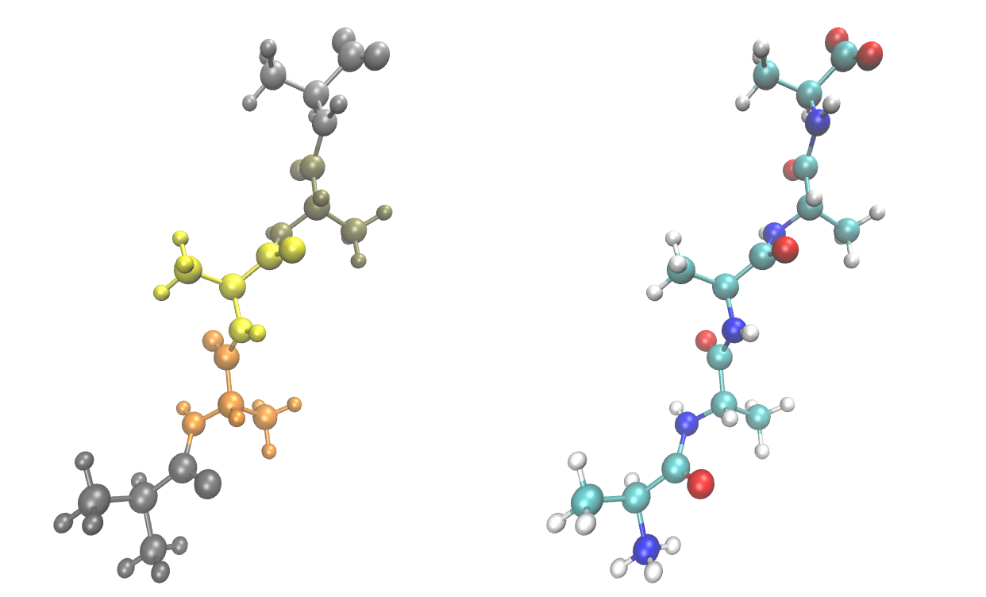

In [10]:
from IPython.display import Image
Image(filename='fig/ala5-two-visualizations.png')

The options of the <b>runAla5</b> method in the next cell are:
 - <em>algorithm</em>: algorithm to use (BH, TRRT, hybrid)
 - <em>pdb</em>: PDB file of the input peptide
 - <em>ffType</em>: type of the force field (amber or charmm) 
 - <em>ffParameters</em>: XML file listing the force field parameters
 - <em>initSample</em>: plain text file listing at least one conformation for initaliwing the explorer
 - <em>movesetMode</em>: moveset method (atomic, global, interpolation)
 - <em>delta</em>: number of steps after what the algorithm attempts to adapt
 - <em>temperature</em>: initial temperature used in the acceptance test
 - <em>tempMode</em>: updating method after the acceptance test (default, probability or energy-range
 - <em>nbSamples</em>: number of samples to record before stopping the algorithm

In [11]:
import re  #regular expressions
import sys #misc system
import os
import pdb
import shutil # python 3 only

def runAla5(algorithm, pdb, ffType = "amber", ffParameters = "data/amber.xml", initSample = None, movesetMode = "atomic", delta = 5, temperature = 2., \
             tempMode = "probability", nbSamples = 10):

    odir = "tmp-results-ala5-%s" % algorithm 
    if os.path.exists(odir):
        os.system("rm -rf %s" % odir)
    os.system( ("mkdir %s" % odir) )
    
    program = None
    if algorithm == "BH":
        program = "sbl-landexp-BH-atomic.exe"
    elif algorithm == "TRRT":
        program = "sbl-landexp-TRRT-atomic.exe"
    elif algorithm == "hybrid":
        program = "sbl-landexp-hybrid-BH-TRRT-atomic.exe"
    # check executable exists and is visible
    exe = shutil.which(program)
    if not exe:
        sys.exit("Executable %s not found, exiting" % program)
    
    print(("Using executable %s\n" % exe))
    if initSample:
        cmd = "%s -v1 -l  --sampling-viewer vmd --cs-pdb-files=%s --ff-type=%s --ff-parameters-filename=%s --init-sample=%s \
                --moveset-mode=%s --temperature=%f \
                --temperature-tuning-mode=%s --nb-samples=%d --directory=%s" \
                % (program, pdb, ffType, ffParameters, initSample, movesetMode, temperature, tempMode, nbSamples, odir)
    else:
        cmd = "%s -v1 -l  --sampling-viewer vmd --cs-pdb-files=%s --ff-type=%s --ff-parameters-filename=%s --moveset-mode=%s \
                --temperature=%f --temperature-tuning-mode=%s \
                --nb-samples=%d --directory=%s" \
                % (program, pdb, ffType, ffParameters, movesetMode, temperature, tempMode, nbSamples, odir)
    if algorithm != "TRRT":
        cmd += " --adaptive-displace-delta=%d" % delta
    print(("Executing %s\n" % cmd))
    os.system(cmd)
        
    cmd = "ls %s" % odir
    ofnames = os.popen(cmd).readlines()
    print(("All output files in %s:" % odir),ofnames)

In [12]:
print("Marker : Calculation Started")
#runAla5("BH", pdb="data/ala5.pdb", initSample = "data/ala5.txt")
#runAla5("TRRT", pdb="data/ala5.pdb", initSample = "data/ala5.txt")
runAla5("hybrid", pdb="data/ala5.pdb", initSample = "data/ala5.txt", nbSamples = 50)
print("Marker : Calculation Ended")

Marker : Calculation Started
Using executable /user/fcazals/home/projects/proj-soft/sbl-install/bin/sbl-landexp-hybrid-BH-TRRT-atomic.exe

Executing sbl-landexp-hybrid-BH-TRRT-atomic.exe -v1 -l  --sampling-viewer vmd --cs-pdb-files=data/ala5.pdb --ff-type=amber --ff-parameters-filename=data/amber.xml --init-sample=data/ala5.txt                 --moveset-mode=atomic --temperature=2.000000                 --temperature-tuning-mode=probability --nb-samples=50 --directory=tmp-results-ala5-hybrid --adaptive-displace-delta=5

All output files in tmp-results-ala5-hybrid: ['sbl-landexp-hybrid-BH-TRRT-atomic__log.txt\n', 'sbl-landexp-hybrid-BH-TRRT-atomic__minima_energies.txt\n', 'sbl-landexp-hybrid-BH-TRRT-atomic__minima.txt\n', 'sbl-landexp-hybrid-BH-TRRT-atomic__minima.vmd\n', 'sbl-landexp-hybrid-BH-TRRT-atomic__minimum10.pdb\n', 'sbl-landexp-hybrid-BH-TRRT-atomic__minimum11.pdb\n', 'sbl-landexp-hybrid-BH-TRRT-atomic__minimum12.pdb\n', 'sbl-landexp-hybrid-BH-TRRT-atomic__minimum13.pdb\n', 's

### As previsouly, we easily retrieve and exploit the samples and local minima generated

In [13]:
# Retrieve selected files
odir =  "tmp-results-ala5-hybrid"
samples = find_file_in_output_directory("samples.txt", odir)
samples_energies = find_file_in_output_directory("samples_energies.txt",  odir)
print("Number of samples:", os.popen( ("wc -l %s" % samples)).readlines())

minima = find_file_in_output_directory("minima.txt",  odir)
minima_energies = find_file_in_output_directory("minima_energies.txt",  odir)

print("Number of local minima:", os.popen( ("wc -l %s" % minima)).readlines())


Number of samples: ['50 tmp-results-ala5-hybrid/sbl-landexp-hybrid-BH-TRRT-atomic__samples.txt\n']
Number of local minima: ['50 tmp-results-ala5-hybrid/sbl-landexp-hybrid-BH-TRRT-atomic__minima.txt\n']


## As done above,  we can also compute a dendogram from the matrix of pairwise distances
Note that sbl-lrmsd-all-pairs.exe from Molecular_distances

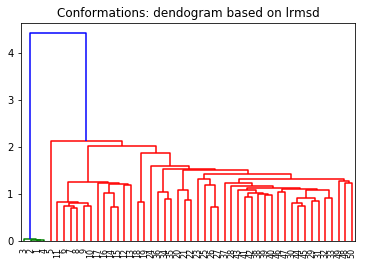

In [16]:
exe = shutil.which("sbl-lrmsd-all-pairs.exe") 
if not exe: 
    print("Executable sbl-lrmsd-all-pairs.exe not found; get it from the package Molecular_distances.")
    
os.system( ("%s --points-file tmp-results-ala5-hybrid/sbl-landexp-hybrid-BH-TRRT-atomic__minima.txt") % exe)
plot_dendogram_of_conformations("all_distances.txt")